In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### KAIST Scene Text Database 전처리기:
1. 데이터 url:http://www.iapr-tc11.org/mediawiki/index.php/KAIST_Scene_Text_Database
1. 압축을 다 풀고 'kaist_dataset'아래에 이미지 데이터와 xml 파일을 두면
1. 각 xml 파일에서 글자하나하나 위치정보를 읽어 원본 이미지에서 글자를 별도의 이미지 파일로 저장하는 작업을 수행한다.
1. 결과물은 char_data 아래에 각 글자명으로 폴더를 만들고 그 아래에 원본파일명.글자명.idx.jpg로 저장
    - char_data/{character}/{img_filename}.{character}.{idx}.jpg
    - character가 .(dot)인 경우에는 {character}값을 dot으로 대체하여 처리
    

In [74]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import xml.etree.ElementTree

from os import listdir, path, makedirs
from os.path import isfile, isdir, join, basename

img_base_path = 'kaist_dataset'

def plot_img_inline(img):
    plt.figure()
    plt.imshow(np.asarray(img))
    plt.show()

char_count = dict()

def get_unique_img_name(target_path, index_name, char_name):
    idx = 0
    image_filename = '%s.jpg' %('_'.join([index_name, str(idx)]))
    full_path = join(target_path, image_filename)
    
    while path.exists(full_path):
        idx = idx + 1
        image_filename = '%s.jpg' %('_'.join([index_name, str(idx)]))
        full_path = join(target_path, image_filename)
    return full_path

def print_img(img, base_path, index_name, char_name):
    target_path = join(base_path, char_name)
    if not path.exists(target_path):
        makedirs(target_path)

    # 이미지 데이터들이 여러 폴더에 걸쳐있어서 같은 파일명과 같은 글자를 갖는 경우가 많음
    # 뒤에 idx값을 추가해 서로 다른 데이터가 다른 파일명을 갖도록 함.
    full_path = get_unique_img_name(target_path, index_name, char_name)
    img.save(full_path)
    
    if char_name not in char_count:
        char_count[char_name] = 1
    else:
        char_count[char_name] = char_count[char_name] + 1
    
def crop_character_images(base_path, index_name, output_path='char_data'):
    image_filename = '.'.join([index_name, 'jpg'])
    xml_filename = '.'.join([index_name, 'xml'])
    
    # xml 파일에 확장자를 빠트린 경우가 많음. xml 파일이 없는 경우에는 xml파일명을 확장자를 제외한 것으로 설정
    if path.exists(join(base_path, xml_filename)) is False:
        xml_filename = index_name
    im = Image.open(join(base_path, image_filename))
    
#     plot_img_inline(im)
    e = xml.etree.ElementTree.parse(join(base_path, xml_filename)).getroot()

    for image in e:
        for words in image:
            if words.tag == 'words':
                for word in words:
                    for char in word:
                        if len(char.attrib['char']) != 1:
                            continue
                            
                        # 글자가 .인경우 dot으로 대체
                        if char.attrib['char'] == '.':
                            char.attrib['char'] = 'dot'
                            
                        # box 영역으로 crop
                        box = (int(char.attrib['x']), int(char.attrib['y']), int(char.attrib['x']) + int(char.attrib['width']), int(char.attrib['y']) + int(char.attrib['height']))
                        region = im.crop(box)
#                         plot_img_inline(region)

                        # 파일로 저장
                        print_img(region, output_path, index_name, char.attrib['char'])

In [76]:
from os import listdir, path, makedirs
from os.path import isfile, isdir, join, basename

img_base_path = 'kaist_dataset'

fail_filenames = []
def get_recursive_dirlist(base_path):
    # dirname을 얻어옴
    sub_dirnames = [f for f in listdir(base_path) if isdir(join(base_path, f))]
    for dirname in sub_dirnames:
        # 각 dirname별로  recursive 호출
        next_base_path = join(base_path, dirname)
        get_recursive_dirlist(next_base_path)
        
        # 현재 dir에 jpg파일이 있는지 확인
        # KAIST데이터셋은 xxx.jpg, xxx.xml, xxx.bmp 형식으로 있기 때문에, 
        # jpg파일 목록을 가져와서 이미지 데이터 목록을 확보
        data_filenames = [path.splitext(f)[0] for f in listdir(next_base_path) if isfile(join(next_base_path, f)) and f.lower().endswith('.jpg')]        
        for x in data_filenames:
            try:
                crop_character_images(next_base_path, x)
            except:
                # 데이터 형식이 잘못된 경우가 많아 exception이 발생한 경우는 그냥 버림. 대신 뭐가 문제였는지만 출력
                print('###EXCEPTION', next_base_path, x)
                fail_filenames.append((next_base_path, x))

# get_recursive_dirlist(img_base_path)

###EXCEPTION kaist_dataset/English/Digital_Camera/(E.S)F-others 4
###EXCEPTION kaist_dataset/Korean/Digital_Camera/E-night 3
###EXCEPTION kaist_dataset/Korean/Digital_Camera/G-others 080116-0079
###EXCEPTION kaist_dataset/Korean/Digital_Camera/indoor1 080119-0001
###EXCEPTION kaist_dataset/Korean/Digital_Camera/outdoor1 99
###EXCEPTION kaist_dataset/Korean/Digital_Camera/outdoor2 080119-0031
###EXCEPTION kaist_dataset/Korean/Digital_Camera/outdoor2 2007-12-08-day-122
###EXCEPTION kaist_dataset/Mixed/Digital_Camera/(C.S)C-outdoor1 063
###EXCEPTION kaist_dataset/Mixed/Digital_Camera/(C.S)C-outdoor1 080119-0003


In [77]:
def read_charlist(base_path):
    char_data = {}
    sub_dirnames = [f for f in listdir(base_path) if isdir(join(base_path, f))]
    for dirname in sub_dirnames:
        # 각 dirname별로  recursive 호출
        next_base_path = join(base_path, dirname)
        
        # 현재 dir에 jpg파일이 있는지 확인
        # KAIST데이터셋은 xxx.jpg, xxx.xml, xxx.bmp 형식으로 있기 때문에, 
        # jpg파일 목록을 가져와서 이미지 데이터 목록을 확보
        data_filenames = [path.splitext(f)[0] for f in listdir(next_base_path) if isfile(join(next_base_path, f)) and f.lower().endswith('.jpg')]        
        
        char_data[dirname] = data_filenames
        
    return char_data
                
char_data = read_charlist('char_data')

dataset = {}
data_charset = {}
for idx, (char, data) in enumerate(char_data.items()):
    print(idx, char, len(data))
#     if len(data) < 900:
#         continue
    if char not in ['0', '1', '2']:
        continue
    
    dataset[char] = data
    for x in data:
        data_charset[x] = char


0 ! 4
1 " 2
2 % 5
3 & 18
4 ' 5
5 ( 8
6 ) 10
7 * 3
8 + 4
9 , 13
10 - 145
11 : 6
12 0 819
13 1 630
14 2 828
15 3 462
16 4 798
17 5 522
18 6 497
19 7 524
20 8 967
21 9 360
22 ? 2
23 \ 1
24 _ 2
25 ` 3
26 A 843
27 b 265
28 C 502
29 D 257
30 dot 88
31 E 1185
32 F 342
33 g 257
34 H 335
35 I 635
36 j 52
37 K 215
38 L 458
39 M 315
40 N 669
41 O 895
42 P 277
43 Q 9
44 R 613
45 S 627
46 T 853
47 U 314
48 V 117
49 W 186
50 X 41
51 y 197
52 z 44
53 ~ 5
54 가 145
55 각 10
56 간 45
57 갇 1
58 갈 27
59 감 13
60 갑 5
61 값 1
62 갓 3
63 강 39
64 같 2
65 개 59
66 객 15
67 갤 5
68 갯 1
69 거 34
70 건 24
71 걸 7
72 검 9
73 겁 2
74 것 9
75 게 37
76 겔 1
77 겠 2
78 겨 1
79 격 4
80 견 6
81 결 6
82 겸 1
83 겹 6
84 경 47
85 계 26
86 고 128
87 골 25
88 곰 2
89 곱 9
90 곳 19
91 공 99
92 과 92
93 관 60
94 광 20
95 교 124
96 구 166
97 국 118
98 군 2
99 굴 3
100 굼 1
101 굿 2
102 궁 20
103 권 14
104 귀 5
105 귄 1
106 규 2
107 균 2
108 그 22
109 극 3
110 근 6
111 글 15
112

In [78]:
from functools import reduce
count = reduce(lambda x, y: x + y, [len(x) for k, x in dataset.items()])
print('count data', count, len(data_charset))

count data 2277 2277


In [79]:
data_charset

label_idx = {x:idx for idx, x in enumerate(sorted(list(set(data_charset.values()))))}

label_idx

data_idxcharset = {fname:label_idx[char] for fname, char in data_charset.items()}
data_idxcharset

{'005_0_0': 0,
 '005_0_1': 0,
 '006_0_0': 0,
 '013_0_0': 0,
 '017_0_0': 0,
 '023_0_0': 0,
 '027_0_0': 0,
 '032_0_0': 0,
 '035_0_0': 0,
 '042_0_0': 0,
 '047_0_0': 0,
 '047_0_1': 0,
 '047_0_2': 0,
 '047_0_3': 0,
 '056_0_0': 0,
 '056_0_1': 0,
 '080116-0058_0_0': 0,
 '080116-0059_0_0': 0,
 '080116-0059_0_1': 0,
 '080116-0065_0_0': 0,
 '080116-0065_0_1': 0,
 '080116-0065_0_2': 0,
 '080116-0084_0_0': 0,
 '080118-0007_0_0': 0,
 '080118-0007_0_1': 0,
 '080118-0007_0_2': 0,
 '080119-0003_0_0': 0,
 '080119-0009_0_0': 0,
 '080119-0009_0_1': 0,
 '080119-0018_0_0': 0,
 '080119-0018_0_1': 0,
 '080119-0018_0_2': 0,
 '080119-0018_0_3': 0,
 '080119-0018_0_4': 0,
 '080119-0018_0_5': 0,
 '080119-0018_0_6': 0,
 '080119-0018_0_7': 0,
 '080119-0030_0_0': 0,
 '080119-0031_0_0': 0,
 '080119-0031_0_1': 0,
 '090_0_0': 0,
 '091_0_0': 0,
 '105_0_0': 0,
 '10_0_0': 0,
 '11_0_0': 0,
 '11_0_1': 0,
 '121_0_0': 0,
 '123_0_0': 0,
 '123_0_1': 0,
 '123_0_2': 0,
 '125_0_0': 0,
 '126_0_0': 0,
 '126_0_1': 0,
 '128_0_0': 0,
 

In [20]:
label_idx

{'0': 0, '1': 1, '2': 2}

In [21]:
data_idxcharset

{'005.0.0': 0,
 '005.0.1': 0,
 '006.0.0': 0,
 '013.0.0': 0,
 '017.0.0': 0,
 '023.0.0': 0,
 '027.0.0': 0,
 '032.0.0': 0,
 '035.0.0': 0,
 '042.0.0': 0,
 '047.0.0': 0,
 '047.0.1': 0,
 '047.0.2': 0,
 '047.0.3': 0,
 '056.0.0': 0,
 '056.0.1': 0,
 '080116-0058.0.0': 0,
 '080116-0059.0.0': 0,
 '080116-0059.0.1': 0,
 '080116-0065.0.0': 0,
 '080116-0065.0.1': 0,
 '080116-0065.0.2': 0,
 '080116-0084.0.0': 0,
 '080118-0007.0.0': 0,
 '080118-0007.0.1': 0,
 '080118-0007.0.2': 0,
 '080119-0003.0.0': 0,
 '080119-0009.0.0': 0,
 '080119-0009.0.1': 0,
 '080119-0018.0.0': 0,
 '080119-0018.0.1': 0,
 '080119-0018.0.2': 0,
 '080119-0018.0.3': 0,
 '080119-0018.0.4': 0,
 '080119-0018.0.5': 0,
 '080119-0018.0.6': 0,
 '080119-0018.0.7': 0,
 '080119-0030.0.0': 0,
 '080119-0031.0.0': 0,
 '080119-0031.0.1': 0,
 '090.0.0': 0,
 '091.0.0': 0,
 '10.0.0': 0,
 '105.0.0': 0,
 '11.0.0': 0,
 '11.0.1': 0,
 '121.0.0': 0,
 '123.0.0': 0,
 '123.0.1': 0,
 '123.0.2': 0,
 '125.0.0': 0,
 '126.0.0': 0,
 '126.0.1': 0,
 '128.0.0': 0,
 

In [18]:
import tensorflow as tf


with tf.Graph().as_default():
    value = tf.read_file('char_data/1/077.1.1.jpg')
    img = tf.image.decode_jpeg(value)
    sess = tf.Session()
    print(sess.run(img))
    
    

[[[ 45  70 111]
  [ 45  70 111]
  [ 45  70 111]
  [ 45  70 111]
  [ 46  69 111]
  [ 46  69 111]
  [ 46  69 111]
  [ 46  69 111]
  [ 42  63 108]
  [ 51  72 117]
  [ 52  73 120]
  [ 45  66 113]
  [ 46  64 114]
  [ 52  70 120]]

 [[ 45  69 113]
  [ 45  69 113]
  [ 45  69 113]
  [ 45  69 113]
  [ 46  69 113]
  [ 46  69 113]
  [ 46  69 113]
  [ 46  69 113]
  [ 48  69 114]
  [ 47  68 115]
  [ 46  67 114]
  [ 46  67 114]
  [ 51  69 119]
  [ 54  72 122]]

 [[ 45  68 118]
  [ 45  68 118]
  [ 45  69 117]
  [ 45  69 117]
  [ 46  68 117]
  [ 46  68 117]
  [ 46  68 115]
  [ 46  68 115]
  [ 52  73 120]
  [ 46  66 116]
  [ 45  63 113]
  [ 48  66 116]
  [ 48  66 116]
  [ 42  60 110]]

 [[ 45  68 122]
  [ 45  68 122]
  [ 45  68 120]
  [ 45  68 120]
  [ 46  67 120]
  [ 46  68 118]
  [ 46  68 118]
  [ 46  68 117]
  [ 39  59 109]
  [ 43  63 113]
  [ 50  68 118]
  [ 54  72 122]
  [ 55  73 121]
  [ 55  73 121]]

 [[ 46  67 124]
  [ 46  67 124]
  [ 46  67 124]
  [ 46  67 124]
  [ 46  67 122]
  [ 46  67 122]


In [80]:
import numpy as np
label_arr = np.reshape(list(data_idxcharset.values()), (-1, 1))
label_arr

array([[0],
       [0],
       [0],
       ..., 
       [2],
       [2],
       [2]])

In [10]:
import tensorflow as tf

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('train_dir', '/tmp/kaist_train_simple',
                           """Directory where to write event logs """
                           """and checkpoint.""")
tf.app.flags.DEFINE_integer('max_steps', 1000,
                            """Number of batches to run.""")
tf.app.flags.DEFINE_boolean('log_device_placement', False,
                            """Whether to log device placement.""")
tf.app.flags.DEFINE_integer('log_frequency', 10,
                            """How often to log results to the console.""")

In [81]:
data_dict = [{'filename':'char_data/' + label + '/' + char + '.jpg', 'label':label} for char, label in data_charset.items()]
import pandas as pd

x = pd.DataFrame(data_dict)
x.to_csv('kaist_dataset.csv', header=False)

In [83]:
data_charset


{'005_0_0': '0',
 '005_0_1': '0',
 '006_0_0': '0',
 '013_0_0': '0',
 '017_0_0': '0',
 '023_0_0': '0',
 '027_0_0': '0',
 '032_0_0': '0',
 '035_0_0': '0',
 '042_0_0': '0',
 '047_0_0': '0',
 '047_0_1': '0',
 '047_0_2': '0',
 '047_0_3': '0',
 '056_0_0': '0',
 '056_0_1': '0',
 '080116-0058_0_0': '0',
 '080116-0059_0_0': '0',
 '080116-0059_0_1': '0',
 '080116-0065_0_0': '0',
 '080116-0065_0_1': '0',
 '080116-0065_0_2': '0',
 '080116-0084_0_0': '0',
 '080118-0007_0_0': '0',
 '080118-0007_0_1': '0',
 '080118-0007_0_2': '0',
 '080119-0003_0_0': '0',
 '080119-0009_0_0': '0',
 '080119-0009_0_1': '0',
 '080119-0018_0_0': '0',
 '080119-0018_0_1': '0',
 '080119-0018_0_2': '0',
 '080119-0018_0_3': '0',
 '080119-0018_0_4': '0',
 '080119-0018_0_5': '0',
 '080119-0018_0_6': '0',
 '080119-0018_0_7': '0',
 '080119-0030_0_0': '0',
 '080119-0031_0_0': '0',
 '080119-0031_0_1': '0',
 '090_0_0': '0',
 '091_0_0': '0',
 '105_0_0': '0',
 '10_0_0': '0',
 '11_0_0': '0',
 '11_0_1': '0',
 '121_0_0': '0',
 '123_0_0': 

image_file Tensor("DecodeCSV_24:1", shape=(), dtype=string)
label Tensor("DecodeCSV_24:2", shape=(), dtype=int32)
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.NotFoundError'>, char_data/E/1.e.1.jpg
	 [[Node: ReaderReadV2_1 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/cpu:0"](WholeFileReaderV2_1, input_producer_2)]]
0 b'char_data/0/005_0_0.jpg'
0 b'char_data/0/005_0_1.jpg'
0 b'char_data/0/006_0_0.jpg'


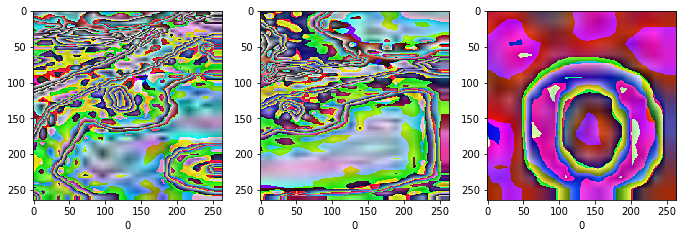

NotFoundError: char_data/E/1.e.1.jpg
	 [[Node: ReaderReadV2_1 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/cpu:0"](WholeFileReaderV2_1, input_producer_2)]]

In [86]:
def get_inputs():
    
    filename_queue = tf.train.string_input_producer(['kaist_dataset.csv'])
    reader = tf.TextLineReader()
    key, value = reader.read(filename_queue)
    
    record_defaults = [[0], [""], [0]]
    _, image_file, label = tf.decode_csv(value, record_defaults=record_defaults)
    
    # Decode the image as a JPEG file, this will turn it into a Tensor which we can
    # then use in training.
    image_orig = tf.image.decode_jpeg(tf.read_file(image_file))
#     image_orig = tf.image.decode_jpeg(image_file)
    image = tf.image.resize_images(image_orig, [264, 264])
    image = tf.image.per_image_standardization(image)
    image.set_shape((264, 264, 3))

    print('image_file', image_file)
    print('label', label)
    
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        
        fig = plt.figure(figsize=(40,250))
        for i in range(3):
            l_value, img_file_value, image_value = sess.run([label, image_file, image])
            subplot = fig.add_subplot(50,10,i+1)
            subplot.set_xlabel(l_value)
            plt.imshow(image_value)
            print(l_value ,img_file_value)
        plt.show()

        coord.request_stop()
        coord.join(threads)             

#     num_preprocess_threads = 1
#     min_queue_examples = 256

#     images, label_batch = tf.train.batch(
#         [image, label],
#         batch_size=FLAGS.batch_size,
#         num_threads=num_preprocess_threads,
#         capacity=min_queue_examples + 3 * FLAGS.batch_size)

# #     tf.summary.image('images', images)
# #     tf.summary.histogram('label_batch', label_batch)
#     return images, tf.reshape(label_batch, [FLAGS.batch_size])

get_inputs()

In [55]:
import re
import time
from datetime import datetime

TOWER_NAME = 'tower'
NUM_CLASSES = len(label_idx)


def _activation_summary(x):
    """Helper to create summaries for activations.

    Creates a summary that provides a histogram of activations.
    Creates a summary that measures the sparsity of activations.

    Args:
      x: Tensor
    Returns:
      nothing
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity',
                      tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):
    """Helper to create a Variable stored on CPU memory.

    Args:
      name: name of the variable
      shape: list of ints
      initializer: initializer for Variable

    Returns:
      Variable Tensor
    """
    with tf.device('/cpu:0'):
        dtype = tf.float16 if FLAGS.use_fp16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var


def _variable_with_weight_decay(name, shape, stddev, wd):
    """Helper to create an initialized Variable with weight decay.

    Note that the Variable is initialized with a truncated normal distribution.
    A weight decay is added only if one is specified.

    Args:
      name: name of the variable
      shape: list of ints
      stddev: standard deviation of a truncated Gaussian
      wd: add L2Loss weight decay multiplied by this float. If None, weight
          decay is not added for this Variable.

    Returns:
      Variable Tensor
    """
    dtype = tf.float16 if FLAGS.use_fp16 else tf.float32
    var = _variable_on_cpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

def inference(images):
    """Build the CIFAR-10 model.

    Args:
      images: Images returned from distorted_inputs() or inputs().

    Returns:
      Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 3, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)
        _activation_summary(conv1)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')
    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)
        _activation_summary(conv2)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm2')
    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                           strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(pool2, [FLAGS.batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)
        _activation_summary(local3)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
        _activation_summary(local4)
    print('local3', local3)
    print('local4', local4)

    # linear layer(WX + b),
    # We don't apply softmax here because
    # tf.nn.sparse_softmax_cross_entropy_with_logits accepts the unscaled logits
    # and performs the softmax internally for efficiency.
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES],
                                              stddev=1 / 192.0, wd=0.0)
        biases = _variable_on_cpu('biases', [NUM_CLASSES],
                                  tf.constant_initializer(0.0))
        
        print('weights', weights)
        print('biases', biases)
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
        
        print('softmax_linear', softmax_linear)
        _activation_summary(softmax_linear)

    return softmax_linear

def _loss(logits, labels):
    """Add L2Loss to all the trainable variables.

    Add summary for "Loss" and "Loss/avg".
    Args:
      logits: Logits from inference().
      labels: Labels from distorted_inputs or inputs(). 1-D tensor
              of shape [batch_size]

    Returns:
      Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')


NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# Constants describing the training process.
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

def _add_loss_summaries(total_loss):
    """Add summaries for losses in CIFAR-10 model.

    Generates moving average for all losses and associated summaries for
    visualizing the performance of the network.

    Args:
        total_loss: Total loss from loss().
    Returns:
        loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    # Attach a scalar summary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op

def ___train(total_loss, global_step):
    """Train CIFAR-10 model.

    Create an optimizer and apply to all trainable variables. Add moving
    average for all trainable variables.

    Args:
    total_loss: Total loss from loss().
    global_step: Integer Variable counting the number of training steps
      processed.
    Returns:
    train_op: op for training.
    """
    # Variables that affect learning rate.
    num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / FLAGS.batch_size
    decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                  global_step,
                                  decay_steps,
                                  LEARNING_RATE_DECAY_FACTOR,
                                  staircase=True)
    tf.summary.scalar('learning_rate', lr)

    # Generate moving averages of all losses and associated summaries.
    loss_averages_op = _add_loss_summaries(total_loss)

    # Compute gradients.
    with tf.control_dependencies([loss_averages_op]):
        opt = tf.train.GradientDescentOptimizer(lr)
        grads = opt.compute_gradients(total_loss)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    # Add histograms for gradients.
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + '/gradients', grad)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
      MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op

def train():
    """Train CIFAR-10 for a number of steps."""
    with tf.Graph().as_default():
        images, labels = get_inputs()
        
        print('labels.get_shape()', labels.get_shape())
        global_step = tf.contrib.framework.get_or_create_global_step()
        
        # Build a Graph that computes the logits predictions from the
        # inference model.
        logits = inference(images)
        
        print('images, logits, labels', images, logits, labels)

        # Calculate loss.
        loss = _loss(logits, labels)

        # Build a Graph that trains the model with one batch of examples and
        # updates the model parameters.
        train_op = ___train(loss, global_step)

        class _LoggerHook(tf.train.SessionRunHook):
            """Logs loss and runtime."""

            def begin(self):
                self._step = -1
                self._start_time = time.time()

            def before_run(self, run_context):
                self._step += 1
                return tf.train.SessionRunArgs(loss)  # Asks for loss value.

            def after_run(self, run_context, run_values):
                if self._step % FLAGS.log_frequency == 0:
                    current_time = time.time()
                    duration = current_time - self._start_time
                    self._start_time = current_time

                    loss_value = run_values.results
                    examples_per_sec = FLAGS.log_frequency * FLAGS.batch_size / duration
                    sec_per_batch = float(duration / FLAGS.log_frequency)

                    format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                                  'sec/batch)')
                    print(format_str % (datetime.now(), self._step, loss_value,
                                        examples_per_sec, sec_per_batch))

        with tf.train.MonitoredTrainingSession(
                checkpoint_dir=FLAGS.train_dir,
                hooks=[tf.train.StopAtStepHook(last_step=FLAGS.max_steps),
                       tf.train.NanTensorHook(loss),
                       _LoggerHook()],
                config=tf.ConfigProto(
                    log_device_placement=FLAGS.log_device_placement)) as mon_sess:
            while not mon_sess.should_stop():
                mon_sess.run(train_op)

train()

image_file Tensor("DecodeCSV:2", shape=(), dtype=string)
label Tensor("DecodeCSV:1", shape=(), dtype=int32)
labels.get_shape() (128,)
local3 Tensor("local3/local3:0", shape=(128, 384), dtype=float32)
local4 Tensor("local4/local4:0", shape=(128, 192), dtype=float32)
weights <tf.Variable 'softmax_linear/weights:0' shape=(192, 3) dtype=float32_ref>
biases <tf.Variable 'softmax_linear/biases:0' shape=(3,) dtype=float32_ref>
softmax_linear Tensor("softmax_linear/softmax_linear:0", shape=(128, 3), dtype=float32)
images, logits, labels Tensor("batch:0", shape=(128, 64, 64, 3), dtype=float32) Tensor("softmax_linear/softmax_linear:0", shape=(128, 3), dtype=float32) Tensor("Reshape:0", shape=(128,), dtype=int32)
INFO:tensorflow:Summary name conv1/weight_loss (raw) is illegal; using conv1/weight_loss__raw_ instead.
INFO:tensorflow:Summary name conv2/weight_loss (raw) is illegal; using conv2/weight_loss__raw_ instead.
INFO:tensorflow:Summary name local3/weight_loss (raw) is illegal; using local3/w

InvalidArgumentError: Expected image (JPEG, PNG, or GIF), got unknown format starting with 'char_data/0/005.'
	 [[Node: DecodeJpeg = DecodeJpeg[acceptable_fraction=1, channels=0, dct_method="", fancy_upscaling=true, ratio=1, try_recover_truncated=false, _device="/job:localhost/replica:0/task:0/cpu:0"](DecodeCSV:2)]]